In [1]:
%cd /home/mrearle/repos/R2R-EnvDrop-ObjAttn/

/mnt-homes/kraken/mrearle/repos/R2R-EnvDrop-ObjAttn


In [2]:
!echo $CUDA_VISIBLE_DEVICES

1


# Imports

In [3]:
import sys
import torch
import networkx as nx

metadata_parser_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser'
if metadata_parser_path not in sys.path:
    sys.path.append(metadata_parser_path)

mattersim_path = '/home/mrearle/datasets/Matterport3DSimulator/build'
if mattersim_path not in sys.path:
    sys.path.append(mattersim_path)
    
src_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src'
if src_path not in sys.path:
    sys.path.append(src_path)


In [4]:
from parse_house_segmentations import HouseSegmentationFile

# Setup Agent

In [5]:
%%capture cap
from importlib import reload
import visualization_v2.agent_utils as agent_utils
reload(agent_utils)
setup_and_run_agent = agent_utils.setup_and_run_agent


In [7]:
%%capture cap
agent_result, object_attentions, viewpoint_attentions = setup_and_run_agent(
    base_name="obj",
    max_obj_number=32,
    obj_aux_task = True,
    include_objs = True,
    reduced_envs = True,
    dataset = "craft",
    logging_vis=True,
    attach_hooks=True,
    get_results=False,
    result_path='/home/mrearle/repos/R2R-EnvDrop-ObjAttn/results/obj/good/craft_obj(32)_aux(0.1)_reduced/good.json'
)

# Visualization

## Parse trajectory data

In [8]:
good_obj_instrs = {'1111_0',
 '1168_0',
 '1182_0',
 '1382_0',
 '1505_0',
 '1825_0',
 '1865_0',
 '1888_0',
 '1907_0',
 '2072_0',
 '2258_0',
 '2290_0',
 '2312_0',
 '2455_0',
 '2489_0',
 '2527_0',
 '2564_0',
 '2658_0',
 '2695_0',
 '2751_0',
 '2757_0',
 '2777_0',
 '295_0',
 '3149_0',
 '321_0',
 '3309_0',
 '3353_0',
 '3433_0',
 '3492_0',
 '3618_0',
 '3709_0',
 '3731_0',
 '3908_0',
 '3915_0',
 '4028_0',
 '412_0',
 '4152_0',
 '4202_0',
 '4235_0',
 '4253_0',
 '4283_0',
 '4330_0',
 '4468_0',
 '4645_0',
 '4676_0',
 '4789_0',
 '4801_0',
 '4859_0',
 '4967_0',
 '4976_0',
 '4982_0',
 '5013_0',
 '5025_0',
 '5038_0',
 '5059_0',
 '5144_0',
 '5198_0',
 '5264_0',
 '5307_0',
 '5412_0',
 '5488_0',
 '5633_0',
 '5840_0',
 '5860_0',
 '601_0',
 '6056_0',
 '6235_0',
 '6366_0',
 '6448_0',
 '64_0',
 '6581_0',
 '6607_0',
 '6751_0',
 '6875_0',
 '6926_0',
 '6940_0',
 '696_0',
 '7120_0',
 '7192_0',
 '7193_0',
 '7247_0',
 '7295_0',
 '805_0',
 '810_0',
 '834_0',
 '878_0',
 '906_0',
 '957_0',
 '998_0'}

In [9]:
import importlib
from visualization_v2 import instruction_utils, iterator_utils, plotting, visualization_data_parser
importlib.reload(visualization_data_parser)
importlib.reload(iterator_utils)
importlib.reload(instruction_utils)
importlib.reload(plotting)

get_result_iterator = iterator_utils.get_traj_result_iterator
map_result_data = iterator_utils.map_result
get_instruction_function = instruction_utils.get_instruction_function
make_plots = plotting.make_plots

In [10]:
get_instruction = get_instruction_function('./semantically_richer_instructions/R2R_craft_val_unseen.json')
result_iterator = get_result_iterator(object_attentions, viewpoint_attentions)

## Plotting

In [11]:
import matplotlib
%matplotlib inline

In [12]:
# Initialize iterator to be able to send environment
next(result_iterator)
result_iterator.send(-1)
pass

In [38]:
# Get environment information and results
# obj_better = 4 (2489_0)
env_i = 4
env_data = map_result_data(env_i, agent_result, result_iterator.send(env_i), get_instruction)
print(env_data['hook_info']['instr_id'])
print(env_data['hook_info']['instr_id'] in good_obj_instrs)

2489_0
True


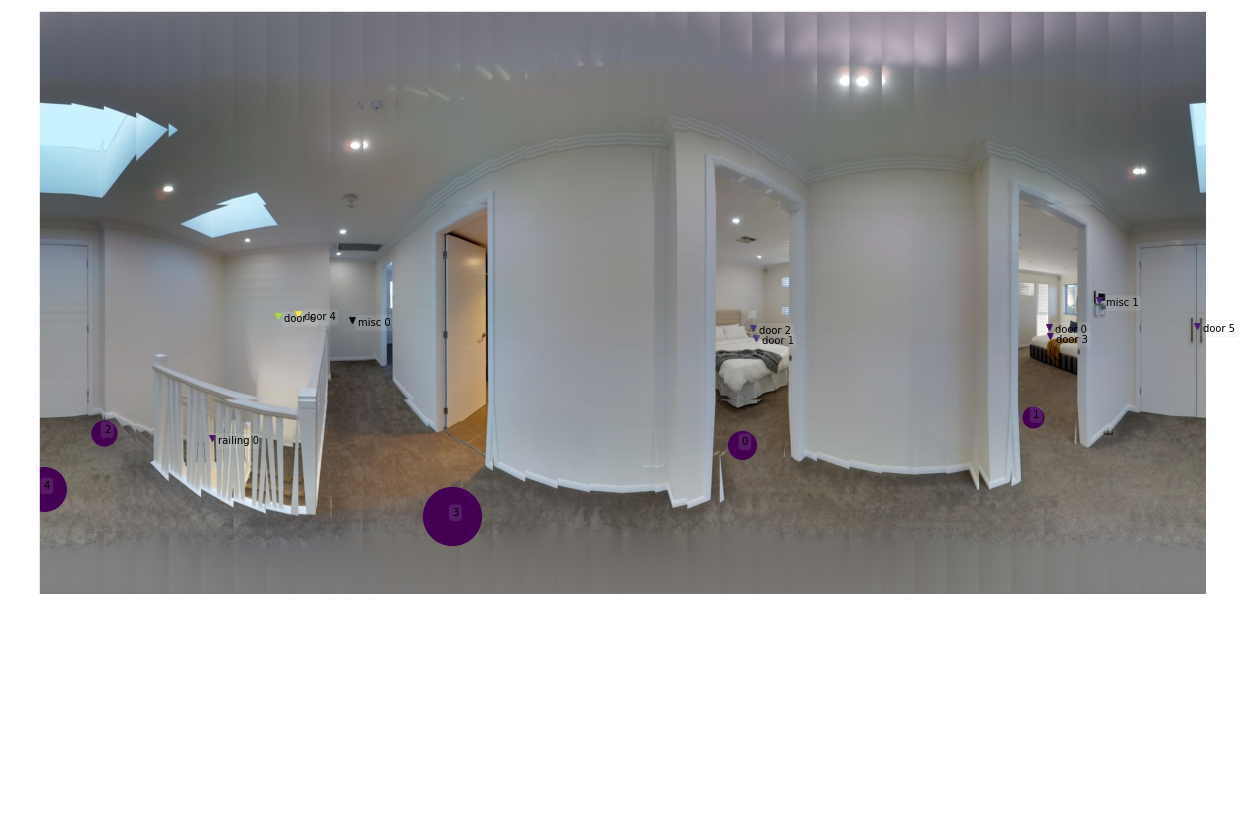

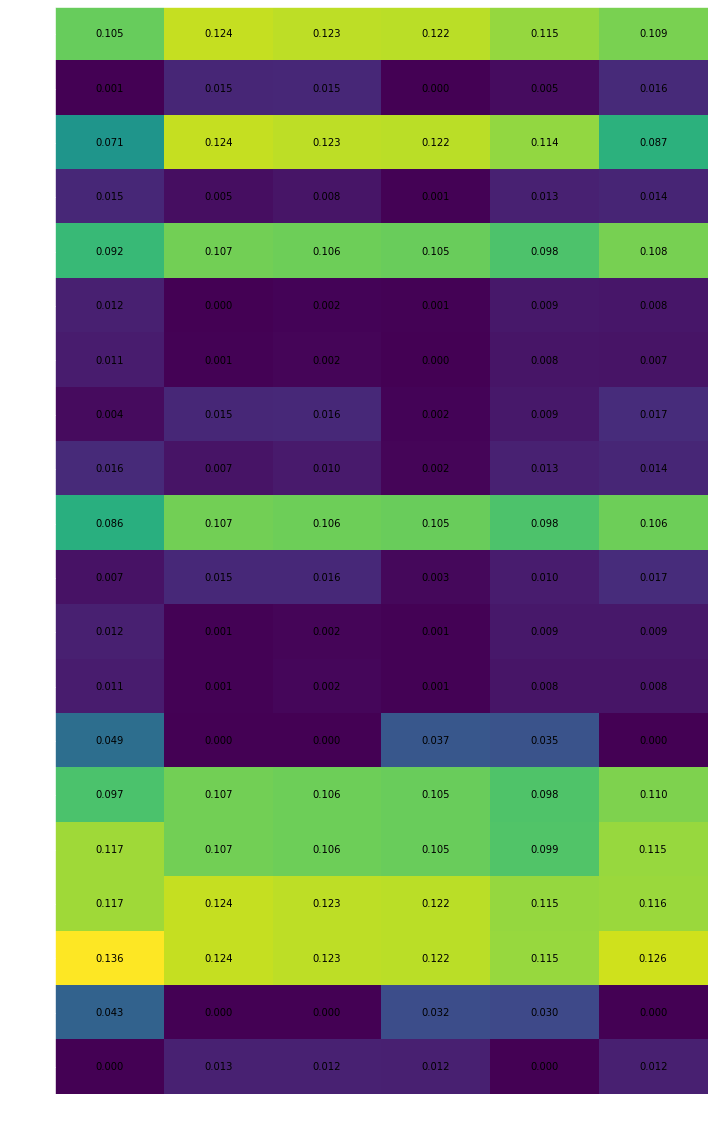

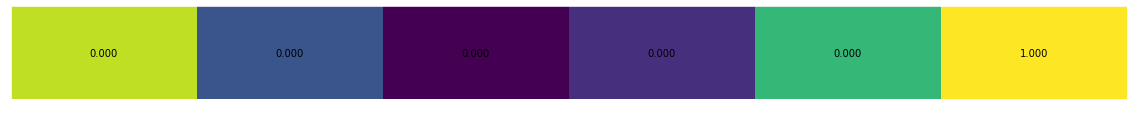

In [39]:
make_plots(
    info=env_data['hook_info'],
    viewpoint_attn=env_data['view_attn'],
    candidates=env_data['viewpoint_names'],
    object_attention=env_data['object_attn'],
    instruction=env_data['instruction'],
)

In [14]:
env_data['agent_trajectory']

['6416ac70316f44d1ae7ec5a3029b1703',
 'de7a74588c2842e9ba391abb153a0257',
 '9b1e2472265c46989eb1c3911aa5971b',
 '81dab76afc424a5b9ab7c7d2432c633f',
 'd9d0b72a2929495cb1fc8df42c84b18a',
 'dc046de639fa43e29b3da505c030f58f']